In [1]:
import pandas as pd
from example.av_discretizer_d1  import AVDiscretizer, Action, Position, Velocity, Rotation
from example.transition import TransitionRecorded
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes

In [2]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
#nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

#FULL
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in
- detected_objects: detected objects in the surrounding of the vehicle


Load the CSV data into a DataFrame


In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'}
df = pd.read_csv(DATAROOT / 'dataset_v1.0-mini_lidar_1.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
df.head()

,modality,scene_token,steering_angle,detect_CAM_FRONT,detect_CAM_BACK,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y,is_destination
0,lidar,2fc3753772e241f2ab2cd16a784cc680,-0.202386,"{('vehicle.bus.rigid', 'vehicle.moving'): 1, (...","{('vehicle.truck', 'vehicle.moving'): 1, ('veh...",2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000,False
1,lidar,2fc3753772e241f2ab2cd16a784cc680,-0.125592,"{('vehicle.car', 'vehicle.moving'): 1, ('vehic...","{('vehicle.truck', 'vehicle.moving'): 1, ('veh...",2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592,False
2,lidar,2fc3753772e241f2ab2cd16a784cc680,-0.410080,"{('vehicle.car', 'vehicle.moving'): 1, ('vehic...","{('vehicle.truck', 'vehicle.moving'): 1, ('veh...",2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.076174,4.108786,False
3,lidar,2fc3753772e241f2ab2cd16a784cc680,-0.591595,"{('vehicle.car', 'vehicle.moving'): 1, ('vehic...","{('vehicle.truck', 'vehicle.moving'): 1, ('veh...",2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681,False
4,lidar,2fc3753772e241f2ab2cd16a784cc680,-0.256491,"{('vehicle.car', 'vehicle.moving'): 1, ('vehic...","{('vehicle.truck', 'vehicle.moving'): 1, ('veh...",2018-08-30 19:25:11.649009,"[-0.19383694099663118, 0.006067266248244902, -...",319.518145,663.938454,0.0,2.751458,3.997839,-0.609336,-0.060543,0.075857,1.994827,False


## Trajectory of AV in a Scene

Let's do an example of computing trajectory of a vehicle in a scene. We then check if the rendering of the scene match the computed trajectory.

In [4]:
# initialize discretizer
av_discretizer = AVDiscretizer()


List of scenes

In [5]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [6]:
scene_test = df['scene_token'].unique()[9]
example_scene_df = df[df['scene_token']==scene_test]
example_scene_df

,modality,scene_token,steering_angle,detect_CAM_FRONT,detect_CAM_BACK,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y,is_destination
343,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.321069,"{('human.pedestrian.adult', 'pedestrian.moving...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:44.547893,"[-0.9627518337207462, -0.007396822537559821, -...",607.454126,1643.214922,0.0,-0.547173,8.459599,-0.110979,-0.054958,0.000000,0.000000,False
344,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.301870,"{('human.pedestrian.adult', 'pedestrian.moving...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:45.047769,"[-0.9586126567859742, -0.00886558613167834, -0...",610.979678,1640.979419,0.0,-0.576383,8.351201,-0.216850,-0.058436,0.074861,4.173894,False
345,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.266963,"{('human.pedestrian.adult', 'pedestrian.moving...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:45.548192,"[-0.9545687821658851, -0.010115361549900212, -...",614.448524,1638.649312,0.0,-0.603276,8.350516,-0.001369,-0.053741,0.063150,4.178313,False
346,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.301870,"{('human.pedestrian.adult', 'pedestrian.moving...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:46.048630,"[-0.9508778105992817, -0.007438394839078251, -...",617.934112,1636.160092,0.0,-0.627174,8.558842,0.416287,-0.047754,0.072299,4.282559,False
347,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.265218,"{('vehicle.car', 'vehicle.moving'): 4, ('human...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:46.549066,"[-0.9462014572093829, -0.01240051736543214, -0...",621.413034,1633.525589,0.0,-0.657550,8.720168,0.322372,-0.060698,0.091490,4.362927,False
348,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.162244,"{('vehicle.car', 'vehicle.moving'): 3, ('human...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:47.048933,"[-0.9429247742619197, -0.010571617513262228, -...",624.903255,1630.734415,0.0,-0.678201,8.940455,0.440690,-0.041313,0.076042,4.468391,False
349,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.106393,"{('vehicle.car', 'vehicle.moving'): 4, ('human...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:47.548824,"[-0.9408639180695122, -0.0013993408319602832, ...",628.343092,1627.868327,0.0,-0.691232,8.956713,0.032524,-0.026068,0.073702,4.476773,False
350,lidar,fcbccedd61424f1b85dcbf8f897f9754,0.003563,"{('vehicle.car', 'vehicle.moving'): 3, ('vehic...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:48.048151,"[-0.9400459441148465, 0.0027504532388893444, -...",631.769556,1624.966390,0.0,-0.696039,8.992504,0.071678,-0.009627,0.051504,4.489904,False
351,lidar,fcbccedd61424f1b85dcbf8f897f9754,0.000072,"{('vehicle.car', 'vehicle.moving'): 4, ('vehic...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:48.548020,"[-0.9408271137099451, -0.0030042154187013242, ...",635.119301,1622.120959,0.0,-0.691399,8.792587,-0.399938,0.009283,0.035750,4.394996,False
352,lidar,fcbccedd61424f1b85dcbf8f897f9754,-0.027853,"{('vehicle.car', 'vehicle.moving'): 4, ('vehic...","{('human.pedestrian.adult', 'pedestrian.moving...",2018-08-01 19:26:49.047890,"[-0.940954152018687, -0.008573445664225235, -0...",638.079084,1619.612347,0.0,-0.690220,7.761774,-2.062163,0.002359,0.045317,3.879613,False


Compute the trajectoy of the scene

In [7]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(example_scene_df)
#recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)
recorder.process_transitions(trajectory)
#recorder.save_to_csv(av_discretizer.unique_states)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

Plot trend of state in time for each instance of a scene.

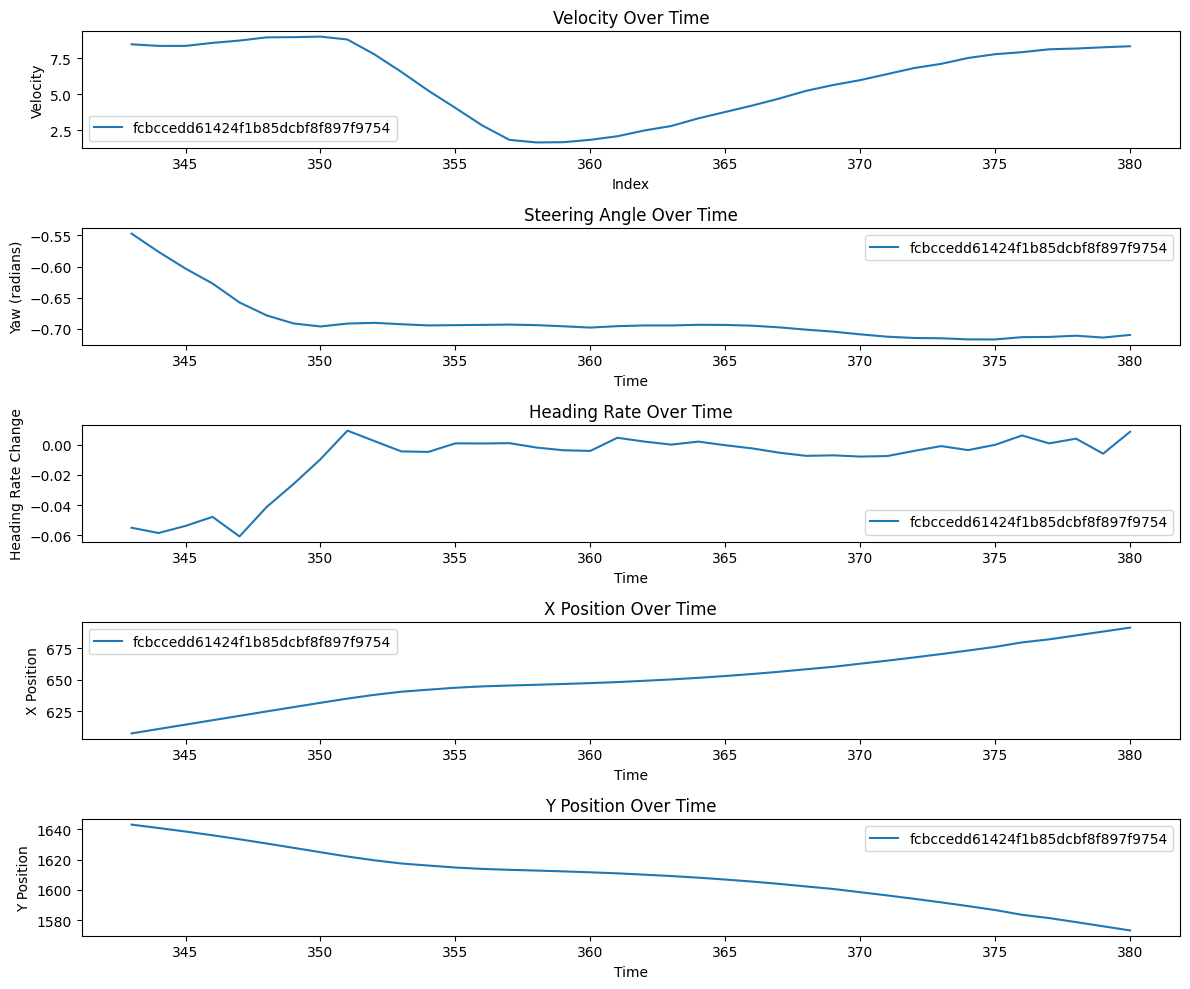

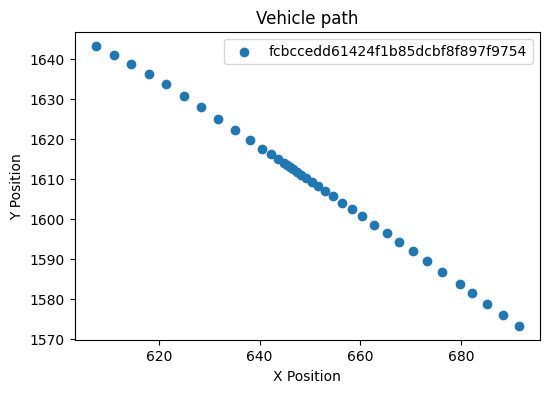

In [8]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=scene_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=scene_token)
plt.title('Steering Angle Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=scene_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=scene_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=scene_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=scene_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [9]:
#nuscenes.render_scene(scene_test)

## All scenes trajectory information


Now, apply the above to all scenes in the dataset.

In [10]:
av_discretizer = AVDiscretizer()
trajectory = av_discretizer.compute_trajectory(df)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [11]:
transition = TransitionRecorded()
transition.process_transitions(trajectory)
transition.save_to_csv(av_discretizer.unique_states, path=str(DATAROOT))

# Policy Graph Generation

In [12]:
env = SelfDrivingEnvironment()
av_discretizer = AVDiscretizer()
pg = PG.PolicyGraph.from_nodes_and_edges(str(DATAROOT / 'nuscenes_nodes.csv'), str(DATAROOT / 'nuscenes_edges.csv'), env, av_discretizer  )

Position(82,165)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(81,165)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(80,165)&Velocity(LOW)&Rotation(SLIGHT_RIGHT)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(79,165)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(79,166)&Velocity(LOW)&Rotation(SLIGHT_RIGHT)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(79,166)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(78,166)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(77,166)&Velocity(LOW)&Rotation(SLIGHT_RIGHT)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)
Position(77,167)&Velocity(LOW)&Rotation(S

In [13]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 233
Number of edges: 273


In [14]:
arbitrary_state = list(pg.nodes)[10]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

(Position(179,451), Velocity(LOW), Rotation(RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
  Times visited: 1
  p(s):          0.003


In [15]:
arbitrary_edge = list(pg.edges)[66]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    (Position(459,216), Velocity(MEDIUM), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
Action:  4
To:      (Position(460,216), Velocity(MEDIUM), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
  Times visited:      1
  p(s_to,a | s_from): 1.000


### Using PG-based policies

In [16]:
from pgeon import PGBasedPolicy, PGBasedPolicyMode, PGBasedPolicyNodeNotFoundMode
import numpy as np

In [17]:
policy_mode = PGBasedPolicyMode.STOCHASTIC
node_not_found_mode = PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES

policy = PGBasedPolicy(pg, policy_mode,node_not_found_mode )
pg._normalize()
print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
print(f'PG number of nodes: {len(policy.pg.nodes)}')
print(f'PG number of edges: {len(policy.pg.edges)}')
        


initial_state = np.array([329.6474941596216, 660.1966888688361, 5.108549775006556, -0.2023862177193762])
data = {
    'detect_CAM_FRONT': "{('vehicle.bus.rigid', 'vehicle.moving'): 1, ('vehicle.construction', 'vehicle.parked'): 1}",
    'detect_CAM_BACK': "{}"#{('vehicle.truck', 'vehicle.moving'): 1, ('vehicle.car', 'vehicle.moving'): 1, ('vehicle.car', 'vehicle.parked'): 2}
        }
objects = pd.Series(data)
   
final_state = np.array([309.1878607795861, 668.6677254778403,  7.946119310024729e-05, -1.2007145498601297])
policy.pg.discretizer.detection_cameras = ['detect_CAM_FRONT', 'detect_CAM_BACK' ]

discretized_obs = policy.pg.discretizer.discretize(initial_state, objects)
str_obs = av_discretizer.state_to_str(discretized_obs)
str_to_state = av_discretizer.str_to_state(str_obs)

action = policy.act(discretized_obs)





Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES
PG number of nodes: 233
PG number of edges: 273
<class 'dict'>
<class 'dict'>
Position(82,165)&Velocity(LOW)&Rotation(FORWARD)&DetectedObjectD1(detect_CAM_FRONT)&DetectedObjectD1(detect_CAM_BACK)


In [18]:
str_to_state

(Position(82,165),
 Velocity(LOW),
 Rotation(FORWARD),
 DetectedObjectD1(detect_CAM_FRONT),
 DetectedObjectD1(detect_CAM_BACK))

Question 1

In [19]:
possible_actions = pg.question1(discretized_obs, verbose=True)

I will take one of these actions:
	-> STRAIGHT 	Prob: 100.0 %


Question 2

In [20]:
action_id = AVDiscretizer.get_action_id(Action.TURN_RIGHT)
best_states = pg.question2(action_id, verbose=True)
                

*********************************
* When do you perform action 3?
*********************************
Most probable in 4 states:
	-> (Position(176,447), Velocity(LOW), Rotation(SLIGHT_RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
	-> (Position(175,446), Velocity(LOW), Rotation(SLIGHT_RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
	-> (Position(177,448), Velocity(LOW), Rotation(SLIGHT_RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
	-> (Position(178,451), Velocity(LOW), Rotation(RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))


In [21]:
policy_modes = [PGBasedPolicyMode.STOCHASTIC, PGBasedPolicyMode.GREEDY]
node_not_found_modes = [PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM, PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES]
action_id = AVDiscretizer.get_action_id(Action.BRAKE)


for policy_mode in policy_modes:
    for node_not_found_mode in node_not_found_modes:
        policy = PGBasedPolicy(pg, mode=policy_mode,  node_not_found_mode=node_not_found_mode)
        greedy = True if policy_mode is PGBasedPolicyMode.GREEDY else False
        print(f'Policy Graph with {policy_mode} and {node_not_found_mode}')
        print()
        print(f'Supposing I was in {str_to_state}, '
            f'if I did not choose to BRAKE was due to...')
        policy.pg._normalize() #do i need to normalize before this step?
        counterfactuals = policy.pg.question3(str_to_state, action_id, greedy, verbose=True)
        
        print()

Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM

Supposing I was in (Position(82,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), if I did not choose to BRAKE was due to...
***********************************************
* Why did not you perform X action in Y state?
***********************************************
I would have chosen: 7
I would have chosen 5 under the following conditions:
Hypothetical state: (Position(81,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
   Actual: <class 'example.av_discretizer_d1.Position'> = Position(82,165) -> Counterfactual: <class 'example.av_discretizer_d1.Position'> = Position(81,165)

Policy Graph with PGBasedPolicyMode.STOCHASTIC and PGBasedPolicyNodeNotFoundMode.FIND_SIMILAR_NODES

Supposing I was in (Position(82,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(det

I would have chosen: 7
I would have chosen 5 under the following conditions:
Hypothetical state: (Position(81,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK))
   Actual: <class 'example.av_discretizer_d1.Position'> = Position(82,165) -> Counterfactual: <class 'example.av_discretizer_d1.Position'> = Position(81,165)

Policy Graph with PGBasedPolicyMode.GREEDY and PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM

Supposing I was in (Position(82,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), if I did not choose to BRAKE was due to...
***********************************************
* Why did not you perform X action in Y state?
***********************************************
I would have chosen: 7
I would have chosen 5 under the following conditions:
Hypothetical state: (Position(81,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObj

# Policy Graph Evaluation and Comparison

## Compute Static Metrics


In [22]:
from example.evaluator import PolicyGraphEvaluator
evaluator = PolicyGraphEvaluator(pg)
entropy_metrics_graph = evaluator.compute_entropy_metrics()

for state, metrics in entropy_metrics_graph.items():
    print(f"State: {state}, H(s): {metrics['Hs']:.2f}, Ha(s): {metrics['Ha']:.2f}, Hw(s): {metrics['Hw']:.2f}")

State: (Position(82,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(81,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(80,165), Velocity(LOW), Rotation(SLIGHT_RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 1.00, Ha(s): 0.00, Hw(s): 1.00
State: (Position(79,165), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(79,166), Velocity(LOW), Rotation(SLIGHT_RIGHT), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 0.00, Ha(s): 0.00, Hw(s): 0.00
State: (Position(79,166), Velocity(LOW), Rotation(FORWARD), DetectedObjectD1(detect_CAM_FRONT), DetectedObjectD1(detect_CAM_BACK)), H(s): 0.00, H

Ideal situation: knowing the current state unqeuivocally determines the following action and state. To evaluate this we use Entropy.

Entropy Interpretation: level of uncertainty of a variable (check PG_position_paper).

- H_a(s): 0 --> state s perfectly determines the following action a.
Too simple graphs with few nodes show larger action uncertainty, making output less reliable.

- H_w(s): 0 --> state s perfectly determines the following state s'.

- H(s): 0 --> state s perfectly determines the following pais of s', a.

## Improve Policy

In [23]:
#path_pg_data = Path('/home/saramontese/Desktop/MasterThesis')

#sub_pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [24]:
#initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
#final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
#print('initial scene state: ', initial_state)
#print('final scene state: ', final_state)

In [25]:
#sub_agent = PGBasedPolicy(sub_pg, mode=PGBasedPolicyMode.GREEDY)
#reward = env.compute_total_reward(sub_agent, initial_state, final_state, max_steps=100)
#print('scene reward before improvement: ', reward)

In [26]:
#reward = env.compute_total_reward(pg)
#print('Total PG reward before improvement: ', reward)

In [27]:
#pg.policy_iteration(sub_pg)
#print('scene reward after improvement: ', env.compute_total_reward(pg))


## Compute Rewards

1. I consider the total pg.
2. I consider each scene as episode, with a initial state and end state
3. For each scene, i compute the reward of the PG.
4. I compute the avg scene reward.

I do this for all the possible pgBased policies.

in which format the scenes?
can i create a function that creates a pg from a dataframe without having to store it the dataframe as csv and then load it?

In [28]:
#for each scenes:
    #initial_state = example_scene_df.iloc[0][['x', "y", "velocity", "yaw"]].values
    #final_state = example_scene_df.iloc[-1][['x', "y", "velocity", "yaw"]].values
    #print('initial scene state: ', initial_state)
    #print('final scene state: ', final_state)